In [1]:
using LinearAlgebra
using Optim
using Plots
using Optim
using LineSearches

# Switch to choose between Float64 and BigFloat
use_bigfloat = true


###########################################################################################
# Custom factorial
###########################################################################################

# Custom factorial function for BigFloat
function factorial_big(x::BigFloat)
    if x == BigFloat(0)
        return BigFloat(1.0)
    else
        return x * factorial_big(x - BigFloat(1))
    end
end

# Custom factorial function for Float64
function factorial_float(x::Float64)
    if x == 0.0
        return 1.0
    else
        return x * factorial_float(x - 1.0)
    end
end

# Factorial function based on switch
factorial(x) = use_bigfloat ? factorial_big(BigFloat(x)) : factorial_float(Float64(x))
###########################################################################################


# Set up the points with BigFloat or Float64
p1 = use_bigfloat ? BigFloat[0.0, 0.0] : [0.0, 0.0]
p2 = use_bigfloat ? BigFloat[1.0, 0.0] : [1.0, 0.0]
p3 = use_bigfloat ? BigFloat[0.0, 1.0] : [0.0, 1.0]

m1 = (p2 .+ p3) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)
m2 = (p1 .+ p3) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)
m3 = (p1 .+ p2) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)

b = (p1 .+ p2 .+ p3) ./ (use_bigfloat ? BigFloat(3.0) : 3.0)

# vertices
T1 = hcat(p1, p2, p3)
eval_T1(i, j) = T1[1, :] .^ (use_bigfloat ? BigFloat(i) : i) .* T1[2, :] .^ (use_bigfloat ? BigFloat(j) : j)

# edge midpoints
T2 = hcat(m1, m2, m3)
eval_T2(i, j) = T2[1, :] .^ (use_bigfloat ? BigFloat(i) : i) .* T2[2, :] .^ (use_bigfloat ? BigFloat(j) : j)

# midpoint
T3 = hcat(b)
eval_T3(i, j) = T3[1, :] .^ (use_bigfloat ? BigFloat(i) : i) .* T3[2, :] .^ (use_bigfloat ? BigFloat(j) : j)

# edge class
T4(a) = hcat(a * p1 .+ (1 .- a) * p2,
             a * p2 .+ (1 .- a) * p1,
             a * p3 .+ (1 .- a) * p1,
             a * p1 .+ (1 .- a) * p3,
             a * p3 .+ (1 .- a) * p2,
             a * p2 .+ (1 .- a) * p3)

eval_T4(a, i, j) = T4(a)[1, :] .^ (use_bigfloat ? BigFloat(i) : i) .* T4(a)[2, :] .^ (use_bigfloat ? BigFloat(j) : j)

# inner class, type 1
T5(a) = hcat(a * m1 .+ (1 .- a) * p1, 
             a * m2 .+ (1 .- a) * p2, 
             a * m3 .+ (1 .- a) * p3)

eval_T5(a, i, j) = T5(a)[1, :] .^ (use_bigfloat ? BigFloat(i) : i) .* T5(a)[2, :] .^ (use_bigfloat ? BigFloat(j) : j)

# inner class, type 2
T6(a, b) =  hcat(b * (a * m1 .+ (1 - a) .* p1) .+ (1 - b) * (a * m2 .+ (1 - a) .* p2),
                 b * (a * m1 .+ (1 - a) .* p1) .+ (1 - b) * (a * m3 .+ (1 - a) .* p3),
                 b * (a * m3 .+ (1 - a) .* p3) .+ (1 - b) * (a * m2 .+ (1 - a) .* p2),
                 b * (a * m2 .+ (1 - a) .* p2) .+ (1 - b) * (a * m1 .+ (1 - a) .* p1),
                 b * (a * m3 .+ (1 - a) .* p3) .+ (1 - b) * (a * m1 .+ (1 - a) .* p1),
                 b * (a * m2 .+ (1 - a) .* p2) .+ (1 - b) * (a * m3 .+ (1 - a) .* p3))

eval_T6(a, b, i, j) = T6(a, b)[1, :] .^ (use_bigfloat ? BigFloat(i) : i) .* T6(a, b)[2, :] .^ (use_bigfloat ? BigFloat(j) : j)

# Integral function using custom factorial
function integral(i, j)
    factorial(j) * factorial(i) / factorial(i + j + 2)
end

# System setup
function Aij(i, j, a)
    vcat(
        sum(eval_T1(i, j)), # trig vertices
        # eval_T2(i, j), # edge midpoints

        sum(eval_T4(a[1], i, j)), # edge class
        sum(eval_T4(a[2], i, j)), # edge class
        


        # eval_T3(i, j), # trig midpoint
        
        sum(eval_T5(a[3], i, j)),
        sum(eval_T5(a[4], i, j)),
        sum(eval_T5(a[5], i, j)),

        sum(eval_T6(a[6],a[7], i, j)),
        sum(eval_T5(a[8], i, j)),
        # sum(eval_T5(a[9], i, j)),
        )
end


# # System setup
# function Aij(i, j, a)
#     vcat(sum(eval_T1(i, j)),
#          sum(eval_T4(a[1], i, j)), # edge class
#          sum(eval_T5(a[2], i, j)),
#          sum(eval_T5(a[3], i, j)))
# end

A(a, order) = hcat([Aij(i, j, a) for i in 0:order for j in 0:order if i + j <= order]...)
rhs(order) = vcat([integral(i, j) for i in 0:order for j in 0:order if i + j <= order]...)

rhs (generic function with 1 method)

In [2]:
freeparam = 8

order = 10
# f(a) = A(a,order)'*((A(a,order) * A(a,order)')\(A(a,order) * rhs(order)))-rhs(order)
f(a) = norm(A(a,order)'*((A(a,order) * A(a,order)')\(A(a,order) * rhs(order)))-rhs(order))

f (generic function with 1 method)

BigFloat[0.3644254864778959909744793881424732332931747544660616788686773211136671335452775, 0.8145837291439574323878979390074179419174611398943813200651916294967036513696712, 0.7547857177224714169581255897517468310120671248497059594061766316444583857503403, 0.1762932597600728440418205319574460444408151032860793779618295172226249967195599, 0.8119788551515355914085923499753125453107949350200140144478700961541695058087953, 0.2490614965339835499717391966722372101825659018261991031412610564724219308629927, 0.4508122927859009452364059972406191465203540647564896954012516423412892940802976, 0.5040943423110548935084791269128168875541358995597439493385641222367166136564265]

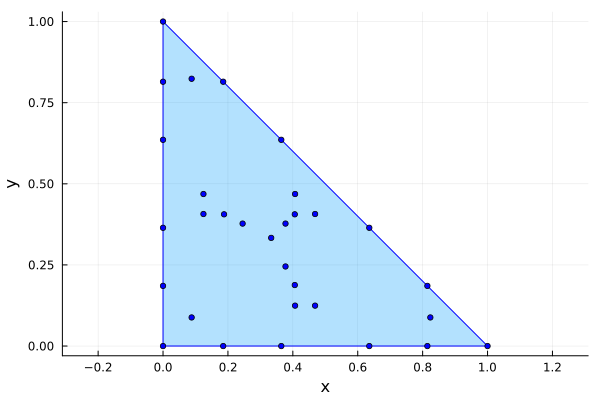

In [3]:
# Define the bounds
# lower_bounds = BigFloat[0.0, 0.0, 0.0]
# upper_bounds = BigFloat[1, 1, 1]
# initial_value = BigFloat[0.1, 0.1, 0.2]

min_val = 0.15
max_val = 0.85
a = min_val .+ (max_val - min_val) .* (use_bigfloat ? BigFloat.(rand(freeparam)) : rand(freeparam))

# a = BigFloat[0.01, 0.01, 0.02]
# a = BigFloat[0.1, 0.1, 0.2] # works!
# a = BigFloat[0.3, 0.23, 0.85, 0.23, 0.31, 0.21, 0.32] #works!
# a = BigFloat[0.3, 0.23, 0.85, 0.23, 0.31, 0.21, 0.32]

print(a)

#########################################################################################################################
# Plotting initial distribution
#########################################################################################################################
using Plots
plot()
# gr()  # Set the backend to GR

# Define the vertices of the triangle
x = [p1[1], p2[1], p3[1], p1[1]]
y = [p1[2], p2[2], p3[2], p1[2]]

# Plot the triangle
plot!(x, y, seriestype = :shape, fillalpha = 0.3, linecolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T1[1, :], T1[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T3[1, :], T3[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T4(a[1])[1, :], T4(a[1])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T4(a[2])[1, :], T4(a[2])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T5(a[3])[1, :], T5(a[3])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[4])[1, :], T5(a[4])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[5])[1, :], T5(a[5])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T6(a[6],a[7])[1, :], T6(a[6],a[7])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

# Add plot title and labels
xlabel!("x")
ylabel!("y")
#########################################################################################################################

In [4]:
# Initialize an array of strings
# bigfloat_strings = [
#     "0.3497563276590531286006952954445668121161354629231253675436650998033682105163362",
#     "0.1168256301165253085822263078463557402695806217250798718929824146309700850615156",
#     "0.5359920624522696018750290486301153617643693213794692184596278721041560647158745",
#     "0.9164715952736393185489606854094341672897032003628564147678514037992402493209116",
#     "0.1285678358785933850614611990426681246047116310691077189241495441532828989922064",
#     "0.1855704466508220428127271513465450386606911784968365895779597754013640528697462",
#     "0.1423596791302088104796922427088486702578148291092101059677756895056200393064595",
#     "0.7432798925094192858277743305767780573199273721370474792622147549960748094153323",
#     "0.2656623668160845723068798650918091304937794310308354680743438212151354872098177",
# ]
# print(a)
# Convert each string to BigFloat with full precision
# a = [parse(BigFloat, x) for x in bigfloat_strings]
# f(a)

# 0.435550025252798077216426997182572878840986513981683599296083745679164511699355
# 0.6637731214588893098777332609060568543103149065899114560422128146835452078278195
# 0.3264161593786625458414059141416173085535859770832105718160910797984164410934227
# 0.3238553555448429211620722851576776397156578278747866410510017646726121931521902
# 0.5240811779919137310112339080707195055864630881706360421103444401091930870961733
# 0.3802763277282470564714697017139324236356332292701035679786790042952726587088819
# 0.3395063654849585434670365174169452616756157045808562770409328931964232367590739

a

8-element Vector{BigFloat}:
 0.3644254864778959909744793881424732332931747544660616788686773211136671335452775
 0.8145837291439574323878979390074179419174611398943813200651916294967036513696712
 0.7547857177224714169581255897517468310120671248497059594061766316444583857503403
 0.1762932597600728440418205319574460444408151032860793779618295172226249967195599
 0.8119788551515355914085923499753125453107949350200140144478700961541695058087953
 0.2490614965339835499717391966722372101825659018261991031412610564724219308629927
 0.4508122927859009452364059972406191465203540647564896954012516423412892940802976
 0.5040943423110548935084791269128168875541358995597439493385641222367166136564265

In [5]:
# println(a)

# td = TwiceDifferentiable(f, a; autodiff = :forward);

# # result = optimize(td, a, Newton(; linesearch = LineSearches.MoreThuente()), Optim.Options(g_tol = 1e-100, iterations = 1000, show_trace = true, show_every = 1, time_limit = 1000))
# # result = optimize(td, a, Newton(; linesearch = LineSearches.BackTracking(), alphaguess = LineSearches.InitialStatic()), Optim.Options(g_tol = 1e-15, iterations = 1000, show_trace = true, show_every = 1, time_limit = 1000))

# result = optimize(td, a, Newton(; linesearch = LineSearches.BackTracking(), alphaguess = LineSearches.InitialStatic()), Optim.Options(g_tol = 1e-63, iterations = 50, show_trace = true, show_every = 10, time_limit = 1000))

# println(result)

# a = Optim.minimizer(result)
# using Base.Threads

# using Distributed

# num_runs = 5

# @threads  for i in 1:num_runs
# a = min_val .+ (max_val - min_val) .* BigFloat.(rand(freeparam))



of = TwiceDifferentiable(f, a; autodiff = :forward)
# # method = Newton(; linesearch = LineSearches.MoreThuente())
method = Newton(; linesearch = LineSearches.BackTracking())


# of = OnceDifferentiable(f, a; autodiff = :forward);
# method = Fminbox(GradientDescent())

options = Optim.Options(g_tol = 1e-20, iterations = 200, show_trace = true, show_every = 10, time_limit = 1000)


# lower_bounds = fill(BigFloat("0"), freeparam)
# upper_bounds = fill(Inf, freeparam)

result = optimize(of, a, method, options)
# result = optimize(of,lower_bounds, upper_bounds, a, method, options)
a = Optim.minimizer(result)
# # end

print(a)

Iter     Function value   Gradient norm 
     0     1.426951e-05     4.109146e-04
 * time: 0.01399993896484375
    10     3.260435e-07     1.329380e-04
 * time: 19.272000074386597
    20     1.816884e-07     1.424231e-03
 * time: 36.18300008773804
    30     9.670196e-08     2.998425e-05
 * time: 52.55900001525879
    40     5.200492e-08     4.505580e-04
 * time: 69.31399989128113
    50     3.693176e-08     2.901497e-03
 * time: 85.54099988937378
    60     2.262268e-08     9.603740e-04
 * time: 102.62199997901917
    70     1.493021e-08     1.085107e-03
 * time: 119.62299990653992
    80     1.239571e-08     1.344189e-04
 * time: 135.85700011253357
    90     8.834290e-09     5.619215e-04
 * time: 152.22099995613098
   100     7.118054e-09     2.716815e-03
 * time: 168.52099990844727
   110     6.084410e-09     1.789766e-03
 * time: 184.06500005722046
   120     5.689523e-09     5.448075e-02
 * time: 199.48099994659424
   130     5.431411e-09     2.951336e+00
 * time: 215.18199992179

In [6]:
result

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     5.221570e-09

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 6.45e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.62e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.32e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.79e-05 ≰ 0.0e+00
    |g(x)|                 = 3.69e+05 ≰ 1.0e-20

 * Work counters
    Seconds run:   325  (vs limit 1000)
    Iterations:    200
    f(x) calls:    402
    ∇f(x) calls:   201
    ∇²f(x) calls:  201


In [7]:
# result2 = optimize(f,
#             a,
#             NelderMead(),
#             autodiff = :forward,
#             Optim.Options(g_tol = 1e-63, iterations = 1000, show_trace = true, show_every = 100, time_limit = 1000))

In [1]:
a = Optim.minimizer(result)

UndefVarError: UndefVarError: `Optim` not defined

In [9]:
(A(a,order) * A(a,order)')\(A(a,order) * rhs(order))

8-element Vector{BigFloat}:
  0.001337294347605540944039049792113760123312083439712791118769141245797526793765672
  0.006554933728934066071599017486217853947552058329624288770699961427336427364426016
 -1.302762821272624585691799988188867693108314537306143225062414833297063399612876e-10
 -1.966926590123174597673653084924860793924116309513179054419488512171903862111076e+24
  0.03348718406054077721414793895175435284747332220686894612418189261702918434889276
  5.099765300058883304110096326931539325987248383074516784990237028433849363260757e+23
  7.284750300586431336313217611284703454355676828716079845873948979092983271958016e+23
  0.04870708723161504995174602744992394936967343836764285693792951697289818176799768

In [10]:
f(a)

5.221570330056814561562534242016819511993367363792893364352168362018537226040165e-09

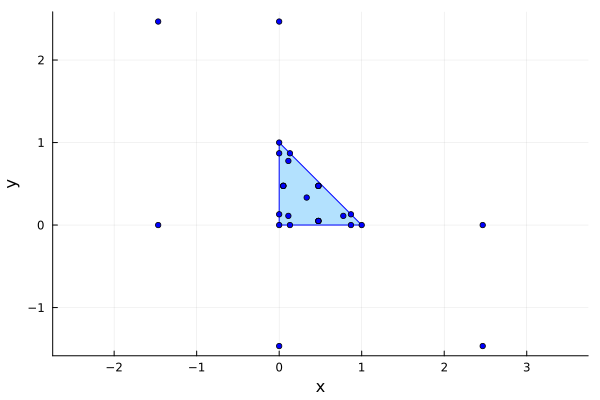

In [11]:
using Plots
# gr()  # Set the backend to GR
plot()
# Define the vertices of the triangle
x = [p1[1], p2[1], p3[1], p1[1]]
y = [p1[2], p2[2], p3[2], p1[2]]

# Plot the triangle
plot!(x, y, seriestype = :shape, fillalpha = 0.3, linecolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T1[1, :], T1[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T3[1, :], T3[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T4(a[1])[1, :], T4(a[1])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T4(a[2])[1, :], T4(a[2])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T5(a[3])[1, :], T5(a[3])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[4])[1, :], T5(a[4])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[5])[1, :], T5(a[5])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T6(a[6],a[7])[1, :], T6(a[6],a[7])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

# scatter!(T5(a[8])[1, :], T5(a[8])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

# Add plot title and labels
xlabel!("x")
ylabel!("y")

# savefig("kek.png")

In [12]:
println(T1)

println(T4(a[1]))
println(T4(a[2]))

println(T5(a[3]))
println(T5(a[4]))
println(T5(a[5]))

BigFloat[0.0 1.0 0.0; 0.0 0.0 1.0]
BigFloat[0.8696568945726084172667091100771468433734518174011098676175978689622874686529294 0.1303431054273915827332908899228531566265481825988901323824021310377125313470728 0.0 0.0 0.8696568945726084172667091100771468433734518174011098676175978689622874686529294 0.1303431054273915827332908899228531566265481825988901323824021310377125313470728; 0.0 0.0 0.1303431054273915827332908899228531566265481825988901323824021310377125313470728 0.8696568945726084172667091100771468433734518174011098676175978689622874686529294 0.1303431054273915827332908899228531566265481825988901323824021310377125313470728 0.8696568945726084172667091100771468433734518174011098676175978689622874686529294]
BigFloat[-1.466299664835777503165039113374435157370437370155825804755801931400296616880424 2.466299664835777503165039113374435157370437370155825804755801931400296616880424 0.0 0.0 -1.466299664835777503165039113374435157370437370155825804755801931400296616880424 2.466299664835777503

In [13]:
integral(1,8)

0.001010101010101010101010101010101010101010101010101010101010101010101010101010095

In [1]:
# using Makie
include("MySimplexQuad.jl")
using .MySimplexQuad


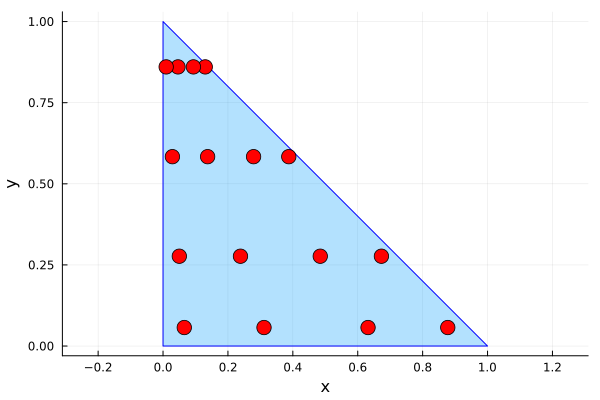

In [16]:
vertices = [
    0.0 0.0
    1.0 0.0
    0.0 1.0
]

# Need at least 4 vertices for plotting?
vertices1 = [vertices; vertices[1:1, :]]

using Plots
plot()

# for npoints in [1,2]
npoints = 4
    X, W = mysimplexquad(BigFloat, npoints, 2)

    # scene = Scene()
    # lines!(scene, vertices1; color = :black, linewidth = 2)
    # scatter!(scene, X[:, 1], X[:, 2]; color = :red, markersize = 0.3 * sqrt.(W))
    # text!(scene, "N=$npoints"; fontsize = 0.15, position = (0.5, 0.9))
    # scale!(scene, 1, 1)

    # Makie.save("figures/gauß-points-$npoints.png", scene; resolution = (300, 300))

    # x = [p1[1], p2[1], p3[1], p1[1]]
    # y = [p1[2], p2[2], p3[2], p1[2]]


    # Plot the triangle
    plot!(vertices1'[1,:], vertices1'[2,:], seriestype = :shape, fillalpha = 0.3, linecolor = :blue, legend = false, aspect_ratio = :equal)
    scatter!(X[:, 1], X[:, 2], markersize = 8, markercolor = :red, legend = false, aspect_ratio = :equal)

    # Add plot title and labels
    xlabel!("x")
    ylabel!("y")
# end

In [13]:
# Integral function using custom factorial
function integral(i, j)
    factorial(j) * factorial(i) / factorial(i + j + 2)
end

rhs(order) = vcat([integral(i, j) for i in 0:order for j in 0:order if i + j <= order]...)
rhs(2)

6-element Vector{Float64}:
 0.5
 0.16666666666666666
 0.08333333333333333
 0.16666666666666666
 0.041666666666666664
 0.08333333333333333

In [12]:
X, W = mysimplexquad(BigFloat, 10, 2)

function integral2(i, j)
    w = 0
    for k=1:length(W)
        w += W[k]*X[k,1]^i*X[k,2]^j
    end
    return w
end

# integral2(1,2)

rhs2(order) = vcat([integral2(i, j) for i in 0:order for j in 0:order if i + j <= order]...)
rhs2(2)

6-element Vector{BigFloat}:
 0.4999999999999999999999999999999999999999999999999999999999999999999999999999827
 0.1666666666666666666666666666666666666666666666666666666666666666666666666666523
 0.0833333333333333333333333333333333333333333333333333333333333333333333333333283
 0.1666666666666666666666666666666666666666666666666666666666666666666666666666544
 0.04166666666666666666666666666666666666666666666666666666666666666666666666666523
 0.0833333333333333333333333333333333333333333333333333333333333333333333333333283